# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

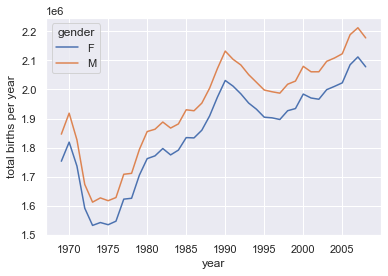

In [60]:
df = pd.read_csv('data/births.csv')

#seperate by gender
female = df.loc[df.gender == "F"].groupby("year").births.sum()
male = df.loc[df.gender == "M"].groupby("year").births.sum()

#plot line graph
fig, ax = plt.subplots(1,1)
ax.plot(female, label='F')
ax.plot(male, label='M')
ax.set_xlabel('year')
ax.set_ylabel('total births per year')
ax.legend(title='gender')

#set dark grid style
sns.set(style='darkgrid')

plt.show()

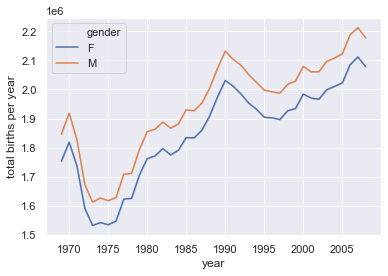

In [59]:
data = pd.read_csv('data/births.csv')
import seaborn as sns

#create a pd.series on the total births per year
birth_ser = pd.Series(data.groupby(['year', 'gender'])['births'].sum())

#merge df and series on year and gender
data = pd.merge(data, birth_ser, on=['year', 'gender'])

#rename new column to represent birhts per year and revert origins
data = data.rename(columns = {'births_y': 'total births per year', 'births_x': 'births'})

#set dark grid style
sns.set(style='darkgrid')

#lineplot
sns.lineplot(x='year', y='total births per year', data=data, hue='gender')

plt.show()

#remove - stevens

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

In [ ]:
# Explanation:

# Relative Number of Births
# In this first plot he plots births per date of the year, probably taken over several years (1969 to 1988). February 29th is a leap-year day, and so is multiplied by 4. 
# He also plots a rolling average to remove higher frequency variation. 
# Finally there is also the mean for the entire dataset, that is normalized to 100. 
# In this graph, outliers and holidays are also circled for reference. 


# Periodic Component
# This is the periodic component of the number of births. It indicates the cyclical patterns, for example there are less births on weekends. 

# Residual
# A residual plot is how much the regression vertically misses a data point. So in this case, from the 'smoothed' line in the first graph to the actual data point. Residual is the observed minus the predicted. Perhaps in this case the 'predicted' takes into consideration the cyclic component seen in the periodic graph (#2) and removes it for the residuals. We also still have outliers and holidays circled for reference. 


# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

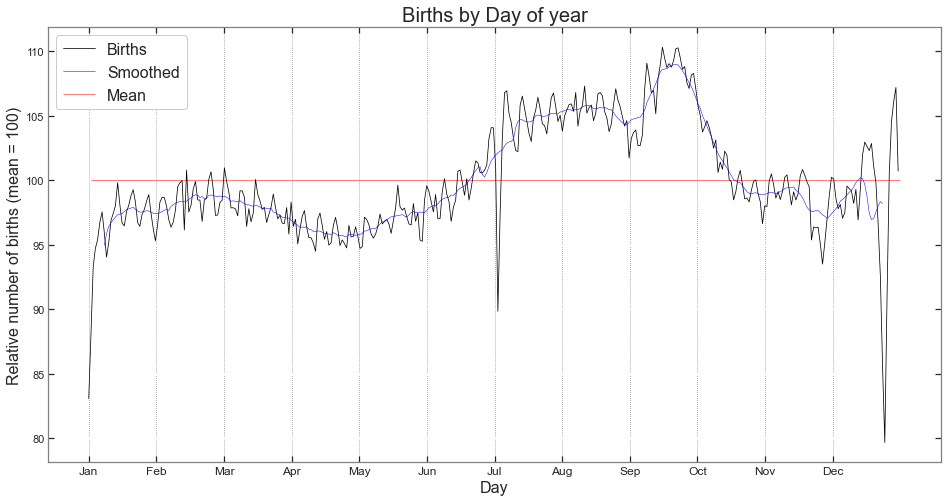

In [481]:
df = pd.read_csv('data/births.csv')
import numpy as np

# cleaning data
condition = (df.day == 99) | (df.day.isnull())
df1 = df.drop(df[condition].index)
condition_2 = (df.month == 2) & ((df.day == 31) | (df.day == 30) | (df.day == 29))
df1 = df1.drop(df[condition_2].index)
df1 = df1.drop(df[(df.month.isin([4,6,9,11])) & (df1.day > 30)].index)

# make x axis a pd.datetime object
df1['date'] = pd.to_datetime(df1[['year','month', 'day']], errors = 'coerce')

fig, ax = plt.subplots(figsize=(16,8))

GB = df1.groupby(['month', 'day'])['births'].mean()

GB_mean = GB.mean()
GB = GB / GB_mean * 100

# for main plot:
GB.plot(color = 'Black', lw = 0.75, label = 'Births', ax=ax)

# for smoothed line: 
GB.rolling(window = 15, center=True).mean().plot(color = 'Blue', lw = 0.5, label = 'Smoothed', ax=ax)  

# for mean line: 
plt.hlines(y = GB.mean(), xmin = GB.index[0], xmax = len(GB), colors = 'red', lw = 0.5, label = 'Mean')

# extras
ax.legend(facecolor = 'white', framealpha = 1, loc='upper left', fontsize = 16)
ax.set_title('Births by Day of year', size=20)
ax.set_xlabel('Day', size=16)
ax.set_ylabel('Relative number of births (mean = 100)', size=16)
ax.tick_params(direction = 'in', top = True, right = True, bottom = True, left = True)
ax.grid(color='grey', axis='x', ls = ':', lw = 0.75)
ax.set_facecolor("white")
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), size=12);

In [ ]:
# #data cleaning / removing outliers
# quartiles = np.percentile(df['births'], [25, 50, 75])
# mu = quartiles[1]
# sig = 0.74 * (quartiles[2] - quartiles[0])
# df = df.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

#from matt, for future reference

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [145]:
recipes_df = pd.read_json('data/recipe.json.gz', compression='infer', lines = True)

recipes_df.description.str.lower().str.contains("breakfast").sum()

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [415]:
recipes_df = pd.read_json('data/recipe.json.gz', compression='infer', lines = True)

def recommend_ingredients(list_ingredients, df):

    total_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley',
                'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']

    for x in total_list: 
        df[x] = df.ingredients.str.lower().str.contains(x)

    for ing in list_ingredients:
        df = df.loc[df[ing] == True]

    return f'Result: The rows where these {len(list_ingredients)} ingredients are in the recipe are {list(df.index)}.'
  

recommend_ingredients(["parsley", "paprika", "tarragon"], recipes_df)

'Result: The rows where these 3 ingredients are in the recipe are [2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 162896, 163175, 165243, 171774].'

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [523]:
import pandas as pd
import zipfile

zf = zipfile.ZipFile('data/archive.zip') 
df_credits = pd.read_csv(zf.open('credits.csv'))
df_movies_meta = pd.read_csv(zf.open('movies_metadata.csv'))
df_credits.crew = df_credits.crew.apply(eval)

In [525]:
def director_finder(credit_crew):
    dir_name = None
    for rows in credit_crew:
        if rows['job'] == 'Director':
            dir_name = rows['name']
    return dir_name

df_credits['director_name'] = df_credits.crew.apply(director_finder)

In [526]:
df_dir_id = df_credits[['id', 'director_name']]
df_dir_id= df_dir_id.astype({"id": str})
df_rat_id= df_movies_meta[['id', 'vote_average' ]]

#merge the 2 dataframes together 
df_merge = pd.merge(df_dir_id, df_rat_id, on = 'id')
df_best_director = df_merge.groupby('director_name').mean('vote_average')
df_best_director = df_best_director[df_best_director['vote_average']==10.0] # only the best of the best

df_best_director

,vote_average
director_name,
A.W. Vidmer,10.0
Amy Schatz,10.0
Ana Poliak,10.0
Andrew Napier,10.0
Andy Picheta,10.0
...,...
Tim Graf,10.0
Todd Grimes,10.0
Will Hay,10.0
